# Louis Gauthy (i6188059) & Louis Meeckers (i6258699)

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import ssl

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model

ssl._create_default_https_context = ssl._create_unverified_context

# Load the data

In [44]:
(x_train, _), (x_test, _) = cifar10.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Print shape
print (x_train.shape)
print (x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


# Reconstruction

## Create autoencoder

In [105]:
latent_dim = 200 # How to find it, should we use it or not?

class Autoencoder(Model):

  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(8, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)),
      layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(12, kernel_size=3, strides=1, padding='same', activation='relu'),
      layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu'),
      layers.UpSampling2D(size=(2, 2)),
      layers.Conv2D(12, kernel_size=3, strides=1, padding='same', activation='relu'),
      layers.UpSampling2D(size=(2, 2)),
      layers.Conv2D(3, kernel_size=3, strides=1, padding='same', activation='relu'),
      # layers.Reshape((32, 32, 3))
      # layers.Dense(3072, activation='sigmoid'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)
# Define optimizer and the error function
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

## Display structure NN

In [112]:
print(autoencoder.summary())

Model: "autoencoder_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_42 (Sequential)   (None, 8, 8, 12)          1100      
_________________________________________________________________
sequential_43 (Sequential)   (None, 32, 32, 3)         3811      
Total params: 4,911
Trainable params: 4,911
Non-trainable params: 0
_________________________________________________________________
None


## Fit the data (epochs=10)

In [106]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1563/1563 [==============================] - 36s 23ms/step - loss: 0.0128 - val_loss: 0.0065
Epoch 2/10
1563/1563 [==============================] - 36s 23ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 3/10
1563/1563 [==============================] - 36s 23ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 4/10
1563/1563 [==============================] - 36s 23ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 5/10
1563/1563 [==============================] - 36s 23ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 6/10
1563/1563 [==============================] - 36s 23ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 7/10
1563/1563 [==============================] - 37s 24ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 8/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 9/10
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 10/10
1563/1563 [==============================] - 38s 24m

In [107]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

## Display some results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


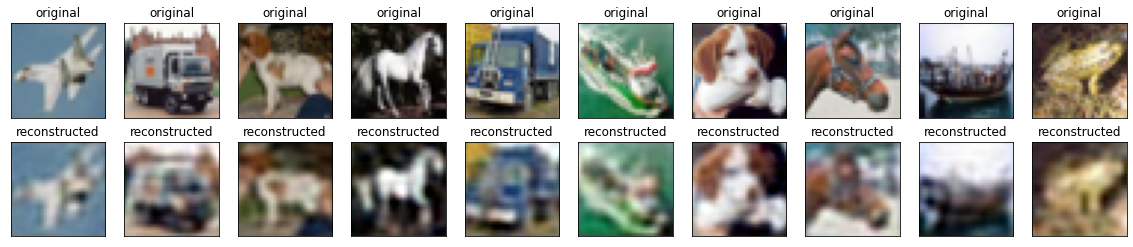

In [110]:
iStart = 10 # only change this value to display different value (must be >= 0)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[iStart + i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[iStart + i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()